# Week 10

**`Library::report`**
* stats
* plotting

In [1]:
# change current working directory
%cd ..

/Users/omega/Developer/qtrader


In [2]:
# suppress warning messages
import warnings
warnings.filterwarnings('ignore')

# trading environment
from qtrader.envs import TradingEnv
# random trading agent
from qtrader.agents import RandomAgent
# uniforma trading agent
from qtrader.agents import UniformAgent
# machine accuracy
from qtrader.utils.numpy import eps

# YAML parser
import yaml

# scientific programming
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt

In [3]:
# fetch configuration file
config = yaml.load(open('config/log/week_10.yaml', 'r'))

# configuration summary
print(f"start date: {config['start_date']}")
print(f"trading frequency: {config['freq']}")
print(f"trading universe: {config['tickers']}")

start date: 2005-01-01
trading frequency: W-FRI
trading universe: ['AAPL', 'GE', 'JPM', 'MSFT', 'VOD', 'GS', 'MMM']


## `stats`

Performance metrics and risk measures.

### Cumulative Returns | Profit & Loss

For a simple returns time-series $r(t) \in \mathbb{R}$:

\begin{align}
    \text{cum_returns}(t)   &= \bigg[ \prod_{\tau=0}^{t} \big[ r(\tau) + 1 \big] \bigg] - 1\\
    \text{profit_n_loss}(t) &= \prod_{\tau=0}^{t} \big[ r(\tau) + 1 \big]
\end{align}

In [4]:
def cum_returns(returns):
    """Computes cumulative returns from simple returns.

    Parameters
    ----------
    returns : np.ndarray | pd.Series | pd.DataFrame
        Returns of the strategy as a percentage, noncumulative.

    Returns
    -------
    cumulative_returns : np.ndarray | pd.Series | pd.DataFrame
        Cumulative returns.
    """
    out = returns.copy()
    out = np.add(out, 1)
    out = out.cumprod(axis=0)
    out = np.subtract(out, 1)
    return out

def pnl(returns):
    """Computes profit and loss (PnL) from simple returns.

    Parameters
    ----------
    returns : np.ndarray | pd.Series | pd.DataFrame
        Returns of the strategy as a percentage, noncumulative.

    Returns
    -------
    pnl : np.ndarray | pd.Series | pd.DataFrame
        Profit and loss.
    """
    if returns.ndim > 2:
        raise ValueError('returns tensor cannot be handled')
    out = returns.copy()
    out = np.add(out, 1)
    out = out.cumprod(axis=0)
    return out

### Sharpe Ratio

For a simple returns time-series $r(t) \in \mathbb{R}$:

\begin{align}
    \text{sharpe_ratio} = \frac{\mu_{r}}{\sigma_{r}}
\end{align}

where:
* $\mu_{r}$: the empirical mean estimator of returns $r(t)$
* $\sigma_{r}$: the empirocal mean (unbiased) estimator of standard deviation of returns $r(t)$

In [5]:
def sharpe_ratio(returns):
    """Computes Sharpe Ratio from simple returns.

    Parameters
    ----------
    returns : np.ndarray | pd.Series | pd.DataFrame
        Returns of the strategy as a percentage, noncumulative.

    Returns
    -------
    sharpe_ratio : float | np.ndarray | pd.Series
        Sharpe ratio.
    """
    if returns.ndim > 2:
        raise ValueError('returns tensor cannot be handled')
    return np.sqrt(len(returns)) * \
        np.mean(returns, axis=0) / (np.std(returns, axis=0) + eps)

### Hit Ratio

For a simple returns time-series $r(t) \in \mathbb{R}$:

\begin{align}
    \text{hit_ratio} = \frac{\text{number of positive trades }}{\text{number of trades}}
\end{align}

In [6]:
def hit_ratio(returns):
    """Computes Hit Ratio from simple returns,
    represented by number of positive trades
    over total number of trades.

    Parameters
    ----------
    returns : np.ndarray | pd.Series | pd.DataFrame
        Returns of the strategy as a percentage, noncumulative.

    Returns
    -------
    hit_ratio : float | np.ndarray | pd.Series
        Hit ratio.
    """
    if returns.ndim > 2:
        raise ValueError('returns tensor cannot be handled')
    return np.sum(returns > 0, axis=0) / len(returns)

### Average Win to Average Loss Ratio

For a simple returns time-series $r(t) \in \mathbb{R}$:

\begin{align}
    \text{average_win_average_loss_ratio} =
        \frac{\mu_{r(t) > 0}}{\mu_{r(t) < 0}}
\end{align}

where:
* $\mu_{r(t) > 0}$: the mean value of positive returns $r(t)$
* $\mu_{r(t) < 0}$: the mean value of negative returns $r(t)$

In [7]:
def awal(returns):
    """Computes Average Win to Average Loss ratio.

    Parameters
    ----------
    returns : np.ndarray | pd.Series | pd.DataFrame
        Returns of the strategy as a percentage, noncumulative.

    Returns
    -------
    awal : float | np.ndarray | pd.Series
        Average win to average loss ratio.
    """
    if returns.ndim > 2:
        raise ValueError('returns tensor cannot be handled')
    aw = returns[returns > 0].mean(axis=0)
    al = returns[returns < 0].mean(axis=0)
    return np.abs((aw+eps)/(al+eps))

### Average Profitability Per Trade

For a simple returns time-series $r(t) \in \mathbb{R}$:

\begin{align}
    \text{average_profitability_per_trade} =
        p_{\text{r(t) > 0}} \mu_{r(t) > 0} - p_{\text{r(t) < 0}} \mu_{r(t) < 0}
\end{align}


where:
* $\mu_{r(t) > 0}$: the mean value of positive returns $r(t)$
* $\mu_{r(t) < 0}$: the mean value of negative returns $r(t)$
* $\\p_{r(t) > 0}$: probability of positive returns $r(t)$ (win)
* $\\p_{r(t) < 0}$: probability of negative returns $r(t)$ (loss)

In [8]:
def appt(returns):
    """Computes Average Profitability Per Trade.

    Parameters
    ----------
    returns : np.ndarray | pd.Series | pd.DataFrame
        Returns of the strategy as a percentage, noncumulative.

    Returns
    -------
    appt : float | np.ndarray | pd.Series
        Average profitability per trade.
    """
    if returns.ndim > 2:
        raise ValueError('returns tensor cannot be handled')
    pw = np.sum(returns > 0, axis=0) / len(returns)
    pl = np.sum(returns < 0, axis=0) / len(returns)
    aw = returns[returns > 0].mean(axis=0)
    al = returns[returns < 0].mean(axis=0)
    return pw * aw - pl * al

### Drawdown

For a cumulative returns time-series $R(t) \in \mathbb{R}$:

\begin{align}
    \text{drawdown}(t) = \max \bigg\{ 0,\ \big[ \max_{\tau \in (0, t)} R(\tau) \big] - R(t) \bigg\}
\end{align}

In [9]:
def drawdown(returns):
    """Computes Drawdown given simple returns.

    Parameters
    ----------
    returns : pandas.Series
        Returns of the strategy as a percentage, noncumulative.

    Returns
    -------
    drawdown : pandas.Series
        Drawdown of strategy.
    """
    _cum_returns = cum_returns(returns)
    expanding_max = _cum_returns.expanding(1).max()
    drawdown = expanding_max - _cum_returns
    return drawdown

### Max Drawdown

For a cumulative returns time-series $R(t) \in \mathbb{R}$:

\begin{align}
    \text{max_drawdown}(t) =
        \max_{x \in (0, t)} \bigg[ \big[ \max_{\tau \in (0, x)} R(\tau) \big] - R(x) \bigg]
\end{align}

In [10]:
def max_drawdown(returns):
    """Computes Max Drawdown given simple returns.

    Parameters
    ----------
    returns : pandas.Series
        Returns of the strategy as a percentage, noncumulative.

    Returns
    -------
    max_drawdown : pandas.Series
        Max drawdown of strategy.
    """
    _drawdown = drawdown(returns)
    return _drawdown.expanding(1).max()

### Other standard metrics


* average_drawdown_time
* mean_returns
* std_returns
* skewness
* kurtosis
* tail_ratio
* value_at_risk
* conditional_value_at_risk

In [11]:
def average_drawdown_time(returns):
    """Computes Average Drawdown Time given simple returns.

    Parameters
    ----------
    returns : pandas.Series
        Returns of the strategy as a percentage, noncumulative.

    Returns
    -------
    average_drawdown_time : datetime.timedelta
        Average drawdown time of strategy.
    """
    _drawdown = drawdown(returns)
    return _drawdown[_drawdown == 0].index.to_series().diff().mean()


def mean_returns(returns):
    """Compute mean returns given simple returns.

    Parameters
    ----------
    returns : pandas.Series
        Returns of the strategy as a percentage, noncumulative.

    Returns
    -------
    mean_returns : float
        Mean returns of strategy.
    """
    return returns.mean(axis=0)


def std_returns(returns):
    """Compute standard deviation of returns given simple returns.

    Parameters
    ----------
    returns : pandas.Series
        Returns of the strategy as a percentage, noncumulative.

    Returns
    -------
    std_returns : float
        Standard deviation of returns of strategy.
    """
    return returns.std(axis=0)


def skewness(returns):
    """Compute skewness of returns given simple returns.

    Parameters
    ----------
    returns : pandas.Series
        Returns of the strategy as a percentage, noncumulative.

    Returns
    -------
    skew_returns : float
        Skewness of returns of strategy.
    """
    return returns.skew(axis=0)


def kurtosis(returns):
    """Compute kurtosis of returns given simple returns.

    Parameters
    ----------
    returns : pandas.Series
        Returns of the strategy as a percentage, noncumulative.

    Returns
    -------
    kurt_returns : float
        Skewness of returns of strategy.
    """
    return returns.kurt(axis=0)


def tail_ratio(returns):
    """Compute tail ratio of returns given simple returns.

    Parameters
    ----------
    returns : pandas.Series
        Returns of the strategy as a percentage, noncumulative.

    Returns
    -------
    tail_ratio : float
        Tail ratio of returns of strategy.
    """
    return np.abs(np.percentile(returns, 95)) / \
        np.abs(np.percentile(returns, 5))


def value_at_risk(returns, cutoff=0.05):
    """Compute Value at risk (VaR) of a returns stream.

    Parameters
    ----------
    returns : pandas.Series
        Returns of the strategy as a percentage, noncumulative.
    cutoff : float, optional
        Decimal representing the percentage cutoff for the bottom percentile of returns.

    Returns
    -------
    VaR : float
        The VaR value.
    """
    return np.percentile(returns, 100 * cutoff)


def conditional_value_at_risk(returns, cutoff=0.05):
    """Compute Conditional value at risk (CVaR) of a returns stream.
    CVaR measures the expected single-day returns of an asset on that asset's
    worst performing days, where "worst-performing" is defined as falling below
    ``cutoff`` as a percentile of all daily returns.

    Parameters
    ----------
    returns : pandas.Series
        Returns of the strategy as a percentage, noncumulative.
    cutoff : float, optional
        Decimal representing the percentage cutoff for the bottom percentile of returns.

    Returns
    -------
    CVaR : float
        The CVaR value.
    """
    cutoff_index = int((len(returns) - 1) * cutoff)
    return np.mean(np.partition(returns, cutoff_index)[:cutoff_index + 1])

## `qtrader.utils.summary.stats`

Wrapper function that generates a statistics summary for provided simple returns.

In [12]:
def stats(returns):
    """Generate statistics report for strategy.

    Parameters
    ----------
    prices: pandas.DataFrame
        Prices of asset universe.
    returns: pandas.Series
        Realised returns of strategy.
    weights: pandas.DataFrame
        Portfolio weights of strategy.

    Returns
    -------
    table: pd.Series
        Strategy report.
    """
    report = {
        'Mean Returns': mean_returns(returns),
        'Cumulative Returns': cum_returns(returns).iloc[-1],
        'Volatility': std_returns(returns),
        'Sharpe Ratio': sharpe_ratio(returns),
        'Max Drawdown': max_drawdown(returns).iloc[-1],
        'Average Drawdown Time': average_drawdown_time(returns).days,
        'Skewness': skewness(returns),
        'Kurtosis': kurtosis(returns),
        'Tail Ratio': tail_ratio(returns),
        'Value at Risk': value_at_risk(returns),
        'Conditional Value at Risk': conditional_value_at_risk(returns),
        'Hit Ratio': hit_ratio(returns),
        'Average Win to Average Loss': awal(returns),
        'Average Profitability Per Trade': appt(returns)
    }
    table = pd.Series(
        report,
        name=(returns.name or 'Strategy'),
        dtype=object
    )
    return table

## `plotting`

Helper plotting functions.

### Time Series

General univariate & multivariate time-series plot.

In [13]:
def time_series(series, title='', xlabel='', ylabel='', path=None):
    """Plot univariate and multivariate time series.

    Parameters
    ----------
    series : np.ndarray | pd.Series | pd.DataFrame
        Univariate / Multivariate time series to plot.
    title: str, optional
        Title for the figure.
    xlabel: str, optional
        Label for x-axis for the figure.
    ylabel: str, optional
        Label for y-axis for the figure.
    path: str, optional
        Path to store figure.
    """
    fig, ax = plt.subplots()
    if isinstance(series, pd.DataFrame) or isinstance(series, pd.Series):
        series.plot(ax=ax)
    elif isinstance(series, np.ndarray):
        if series.ndim == 1:
            plt.plot(series)
        elif series.ndim == 2:
            for c in range(series.shape[1]):
                plt.plot(series[:, c])
        else:
            raise ValueError('returns tensor cannot be handled')
    ax.set(title=title,
           xlabel=xlabel,
           ylabel=ylabel)
    ax.xaxis.set_tick_params(rotation=45)
    if path is not None:
        fig.savefig(path)
    fig.show()

### Profit and Loss

Illustrate profit and loss time-series evolution.

In [14]:
def pnl_plotting(returns, path=None):
    """Plot profit and loss (PnL) from simple returns.

    Parameters
    ----------
    returns : np.ndarray | pd.Series | pd.DataFrame
        Returns of the strategy as a percentage, noncumulative.
    path: str, optional
        Path to store figure.
    """
    _pnl = _PnL(returns)
    if hasattr(returns, 'name'):
        title = f"{returns.name or 'Strategy'}: Profit & Loss"
    else:
        title = 'Profit & Loss'
    xlabel = 'Time'
    ylabel = 'Wealth Level'
    time_series(_pnl, title, xlabel, ylabel, path)

### Trades

Double axes figure, depicted asset prices along with portfolio weights.

In [15]:
def trades(prices, weights, path=None):
    """Plot stock prices and corresponding portfolio weights.

    Parameters
    ----------
    prices : pandas.Series
        Asset prices.
    weights: pandas.Series
        Portfolio weights.
    path: str, optional
        Path to store figure.
    """
    fig, axes = plt.subplots(nrows=2, sharex=True, gridspec_kw={
        'height_ratios': [3, 1], 'wspace': 0.01})
    axes[0].plot(prices.index, prices.values, color='b')
    axes[1].bar(weights.index, weights.values, color='g')
    axes[0].set(title='%s: Prices & Portfolio Weights' % (prices.name or 'Strategy'),
                ylabel='Price, $p_{t}$')
    axes[1].set(xlabel='Time', ylabel='Weight, $w_{t}$', ylim=[0, 1])
    axes[1].xaxis.set_tick_params(rotation=45)
    fig.subplots_adjust(hspace=.0)
    if path is not None:
        fig.savefig(path)
    fig.show()

### Drawdown

Plot drawdown, max drawdown and PnL in a single figure.

In [16]:
def drawdown_plotting(returns, path=None):
    """Plot drawdown along with PnL.

    Prameters
    ---------
    returns: pandas.Series
        Returns of the strategy as a percentage, noncumulative.
    path: str, optional
        Path to store figure.
    """
    _pnl = pnl(returns)
    neg_drawdown = - drawdown(returns)
    neg_max_drawdown = - max_drawdown(returns)
    fig, ax = plt.subplots()
    _pnl.plot(label='Profit & Loss', ax=ax)
    neg_drawdown.plot(label='Drawdown', ax=ax)
    neg_max_drawdown.plot(label='Max Drawdown', ax=ax)
    ax.set(title=f'{returns.name or "Strategy"}: Profit & Loss with Drawdown',
           ylabel='Wealth Level', xlabel='Time')
    ax.legend()
    if path is not None:
        fig.savefig(path)
    fig.show()

## `qtrader.utils.summary.figure`

Wrapper function that generates figures for provided prices, simple returns and portfolio weights.

In [17]:
def figure(prices, returns, weights, path=None):
    """Generate statistics figures for strategy.

    Parameters
    ----------
    prices: pandas.DataFrame
        Prices of asset universe.
    returns: pandas.Series
        Realised returns of strategy.
    weights: pandas.DataFrame
        Portfolio weights of strategy.
    path: str, optional
        Path to store figure.
    """
    drawdown_plotting(returns, path)
    for ticker in prices:
        trades(prices[ticker], weights[ticker], path)

## `summary`

Combine statistics summary report and figures generatio, leveraging `env.agents` and `env._prices` structures.

In [18]:
def summary(prices, agents):
    """Generate statistics summary and figures.

    Returns
    -------
    table: pd.DataFrame
        Strategy report.
    """
    summary = {}
    for agent in agents:
        returns = agents[agent].rewards.sum(axis=1)
        returns.name = agent
        weights = agents[agent].actions
        # set name for figures
        weights.name = agent
        # statistics summary
        summary[agent] = stats(returns)
        # summary figures
        figure(prices, returns, weights)
    return pd.DataFrame(summary)

## Initializations

Setup trading environment and (simple) agents.

In [19]:
# initializa environment
env = TradingEnv(config['tickers'],
                 start_date=config['start_date'],
                 csv=config['csv_file_prices'])
# initialize random agent
random_agent = RandomAgent(env.action_space)
# initialize uniform agent
uniform_agent = UniformAgent(env.action_space)
# register agents
env.register(random_agent)
env.register(uniform_agent)

# environment execution
ob = env.reset()
reward = 0.0
done = False
info = {}
j = 0
while (not done) and (j < env._max_episode_steps):
    random_action = random_agent.act(ob)
    uniform_action = uniform_agent.act(ob)
    ob_, reward, done, info = env.step({
        random_agent.name: random_action,
        uniform_agent.name: uniform_action
    })
    random_reward = reward[random_agent.name]
    uniform_reward = reward[uniform_agent.name]
    ob = ob_
    j = j + 1

/Users/omega/Developer/qtrader/.env/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/omega/Developer/qtrader/.env/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/omega/Developer/qtrader/.env/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/omega/Developer/qtrader/.env/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/omega/Developer/qtrader/.env/lib/python3.6/site-packages/matplotl

,random,uniform
Mean Returns,0.000456086,0.000552743
Cumulative Returns,2.29462,3.60534
Volatility,0.013352,0.0128513
Sharpe Ratio,1.94704,2.4516
Max Drawdown,0.980124,0.944161
Average Drawdown Time,17,13
Skewness,0.315662,0.244315
Kurtosis,12.2488,11.8546
Tail Ratio,0.965489,0.948755
Value at Risk,-0.0190785,-0.0186076


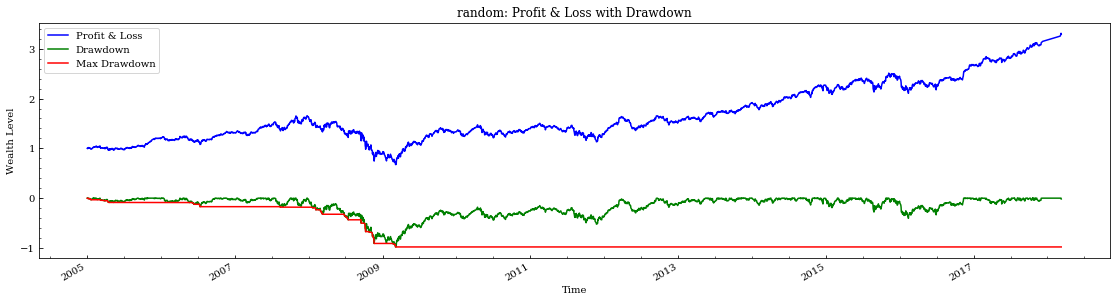

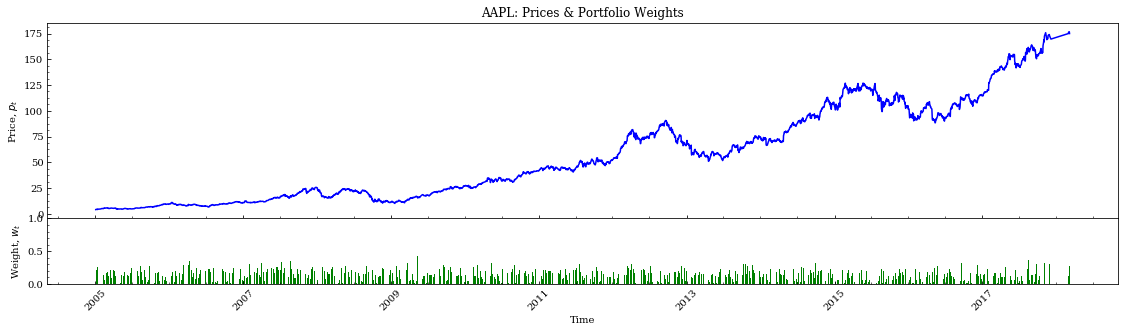

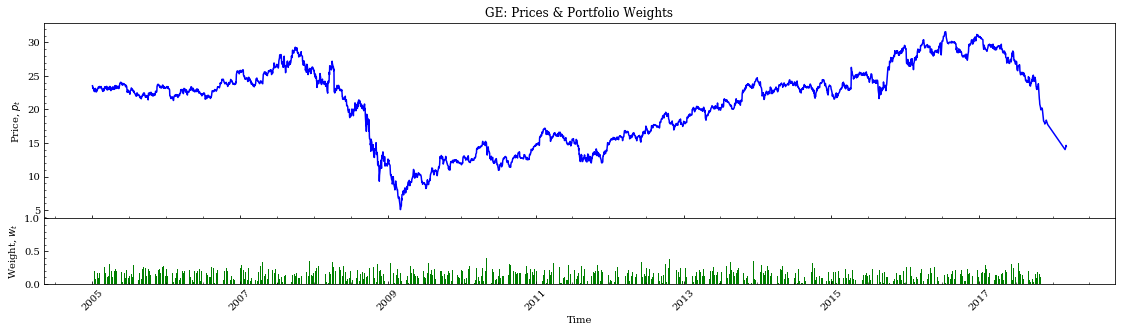

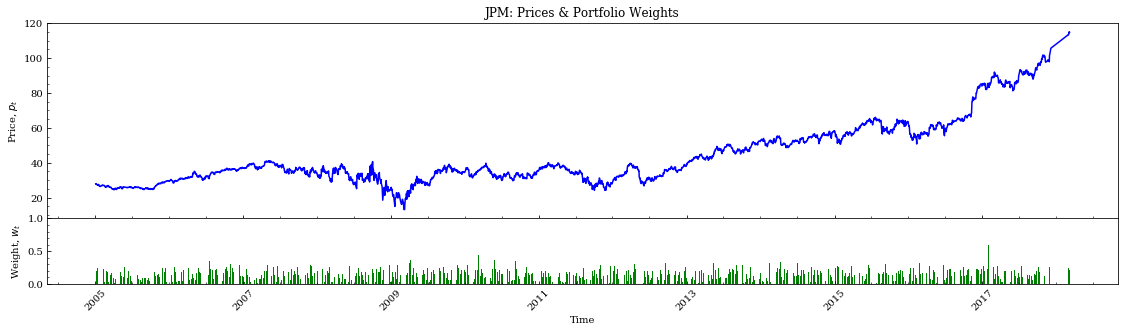

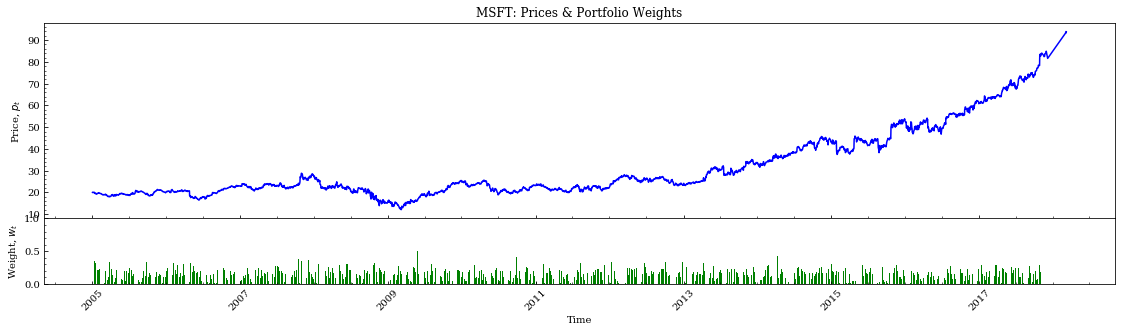

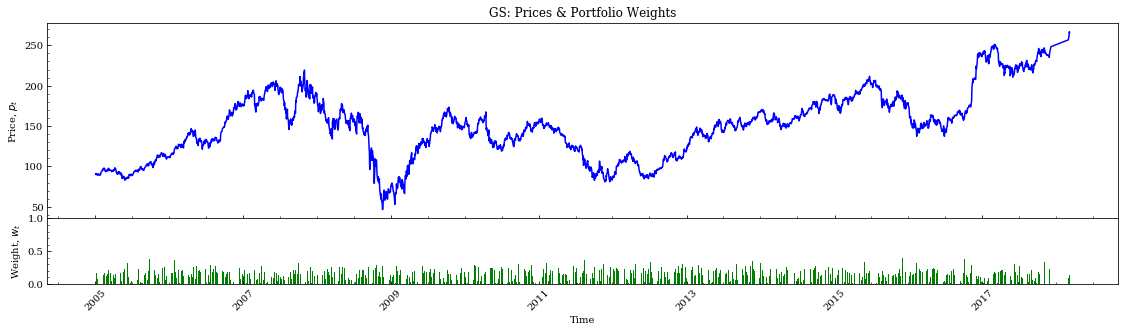

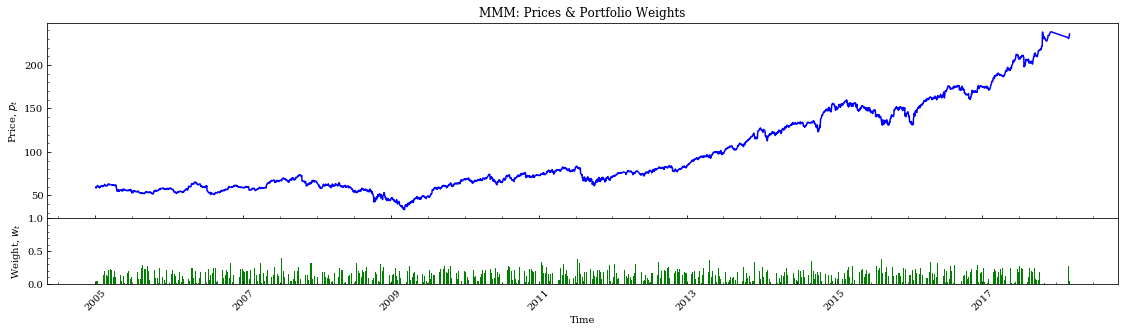

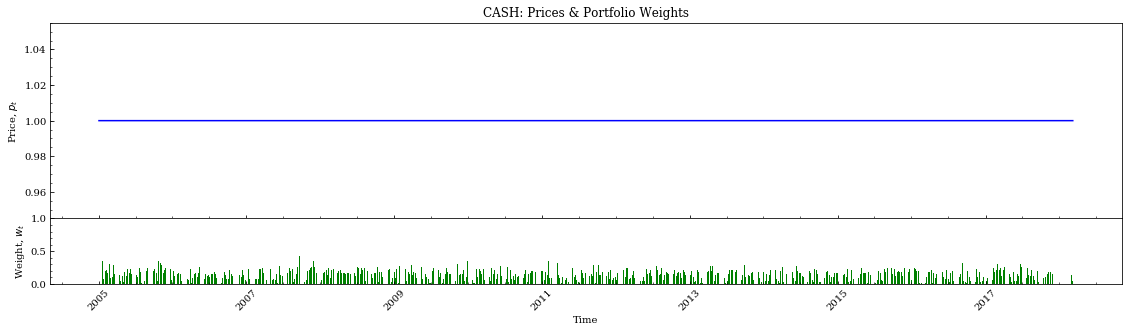

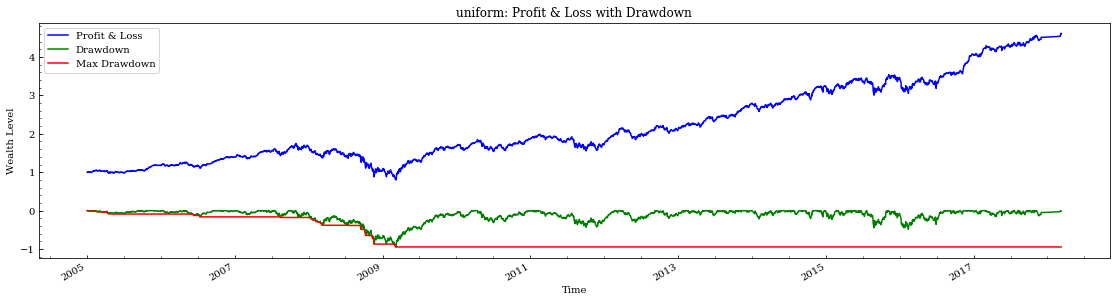

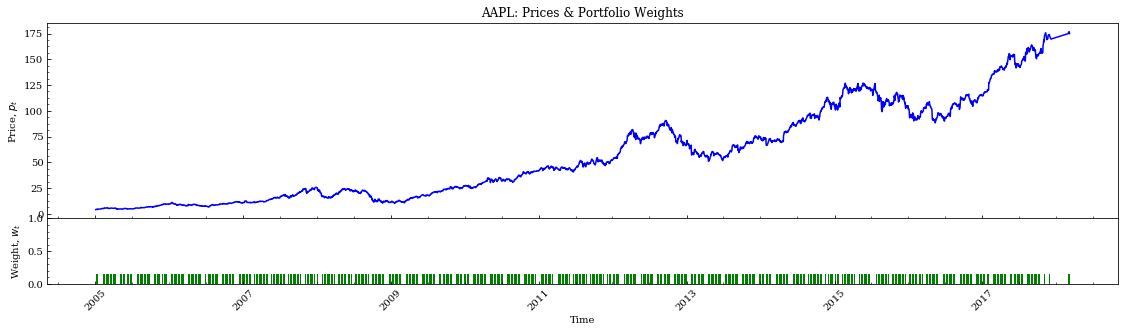

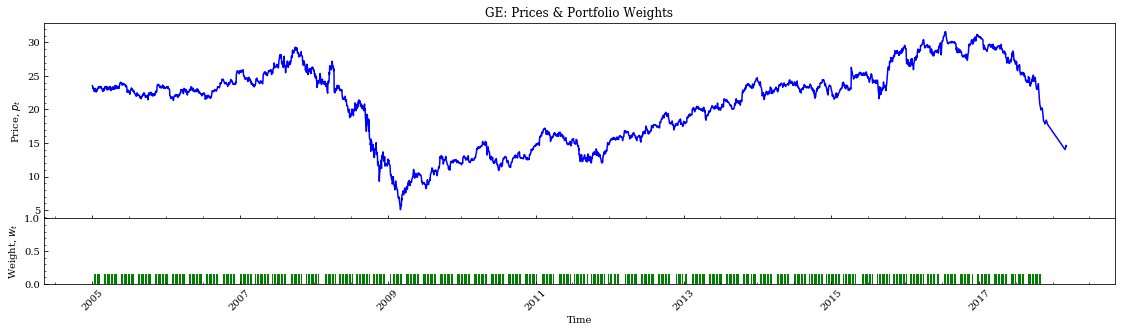

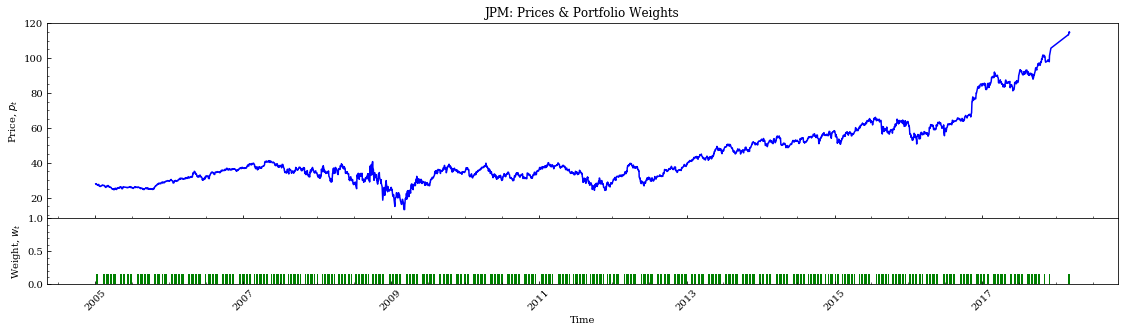

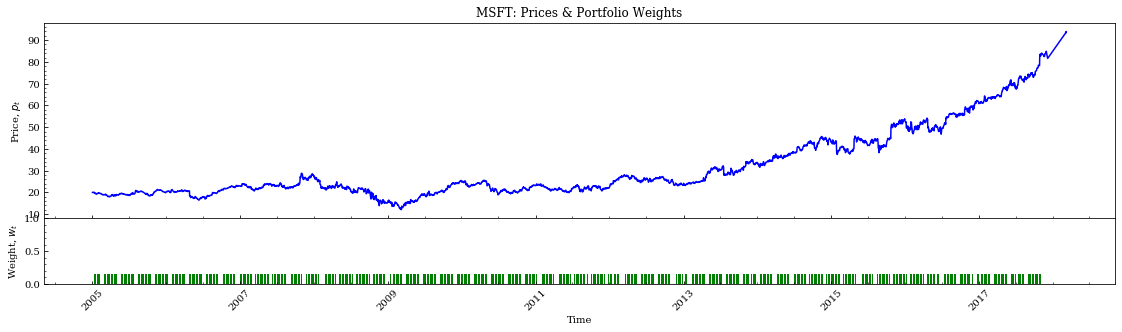

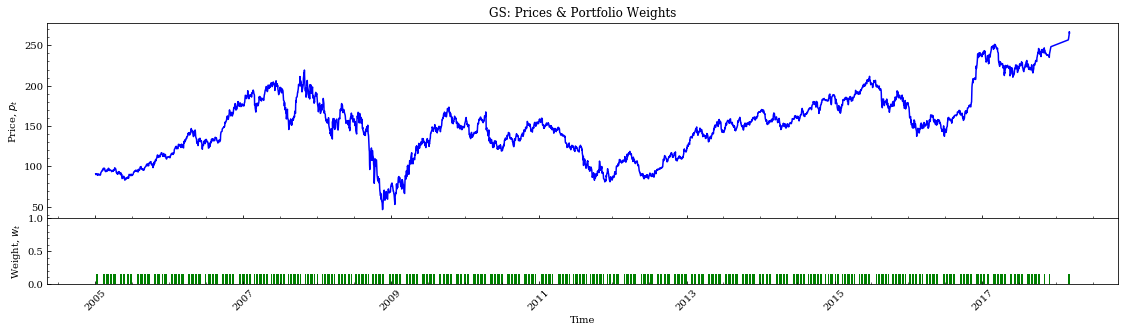

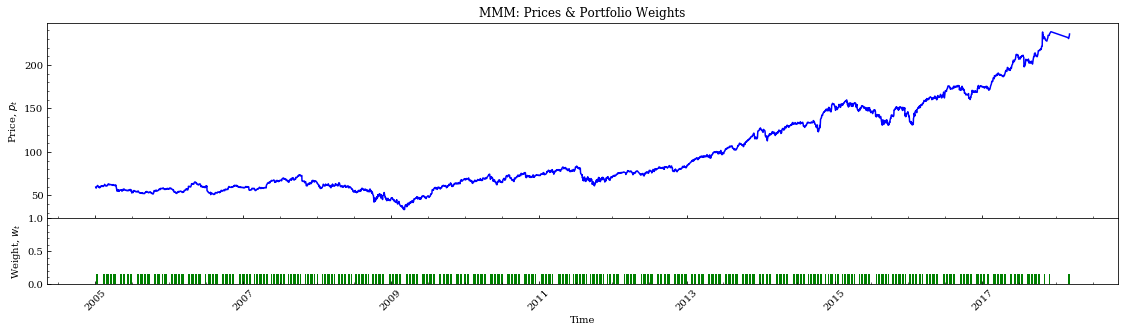

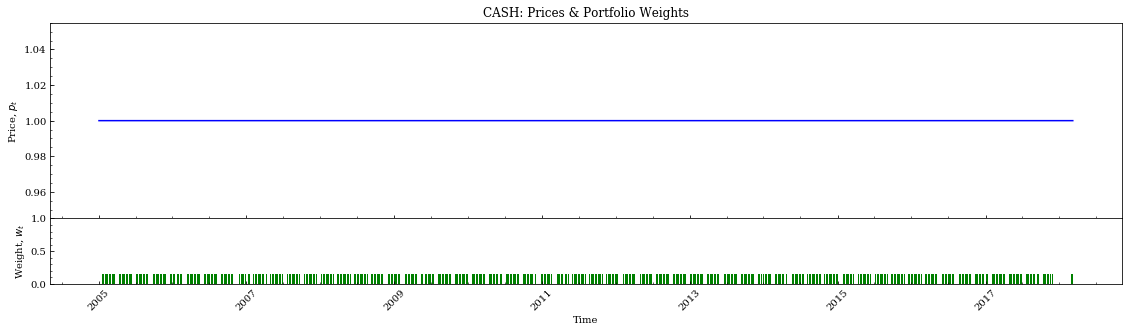

In [20]:
# extend figure sizes
plt.rcParams['figure.figsize'] = [19.2, 4.8]
# generate summary
summary(env._prices, env.agents)